In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

In [9]:
def compute_tpr_fpr(mask):
    tp=[]
    fn=[]
    fp=[]
    tn=[]

    tp_cnt = 0      # 1의 개수 (상향)
    fp_cnt = 0      # 0의 개수 (상향)
    for i, m in enumerate(mask):
        if m == 1:
            tp_cnt += 1
            tp.append(tp_cnt)
            fp.append(fp_cnt)
        else:
            fp_cnt += 1
            tp.append(tp_cnt)
            fp.append(fp_cnt)
    
    fn_cnt = tp_cnt     # 1의 개수 (하향)
    tn_cnt = fp_cnt     # 0의 개수 (하향)
    for i, m in enumerate(mask):
        if m == 1:
            fn_cnt -= 1
            fn.append(fn_cnt)
            tn.append(tn_cnt)
        else:
            tn_cnt -= 1
            fn.append(fn_cnt)
            tn.append(tn_cnt)

    precision = [a/(a+b) for (a, b) in zip(tp, fp)]      #      tp/tp+fp
    recall = [a/(a+b) for (a, b) in zip(tp, fn)]         # tpr: tp/tp+fn
    specificity = [a/(a+b) for (a, b) in zip(tn, fp)]    # tnr: tn/tn+fp
    fpr = [1-a for a in specificity]                     # fpr: 1-specificity
    print(mask)
    print(f"precision={precision}")
    print(f"recall={recall}")
    print(f"fpr={fpr}")

    return precision, recall, fpr

precision=[1.0, 1.0, 0.6666666666666666, 0.75, 0.8, 0.6666666666666666, 0.7142857142857143, 0.75, 0.7777777777777778, 0.8, 0.8181818181818182, 0.8333333333333334, 0.8461538461538461, 0.7857142857142857, 0.8, 0.8125, 0.8235294117647058, 0.8333333333333334, 0.7894736842105263, 0.8, 0.8095238095238095, 0.7727272727272727, 0.7391304347826086, 0.7083333333333334, 0.68, 0.6538461538461539, 0.6296296296296297, 0.6071428571428571, 0.5862068965517241, 0.6, 0.5806451612903226, 0.5625, 0.5454545454545454, 0.5294117647058824, 0.5142857142857142, 0.5, 0.4864864864864865, 0.47368421052631576, 0.46153846153846156, 0.45, 0.43902439024390244, 0.42857142857142855, 0.4186046511627907, 0.4090909090909091, 0.4, 0.391304347826087, 0.40425531914893614, 0.3958333333333333, 0.3877551020408163, 0.38, 0.37254901960784315, 0.36538461538461536, 0.3584905660377358, 0.35185185185185186, 0.34545454545454546, 0.3392857142857143, 0.3333333333333333, 0.3275862068965517, 0.3220338983050847, 0.31666666666666665, 0.3114754

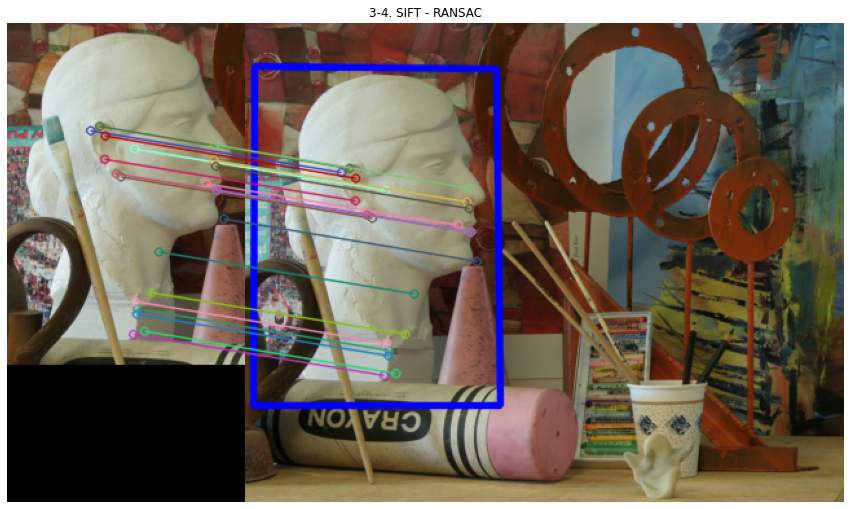

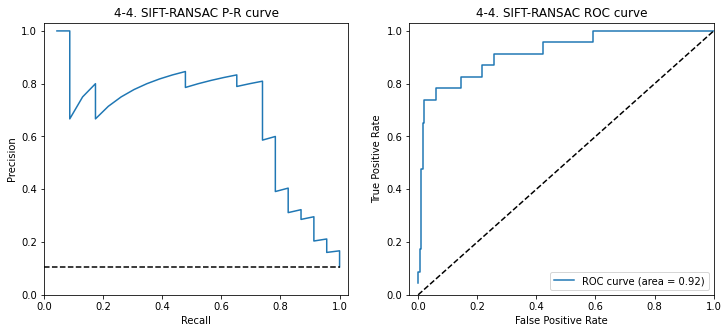

In [8]:
# Load the main image and template image
img2 = cv2.imread('./img/Art/view5.png')
img1 = cv2.imread('./template.png')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

detector = cv2.xfeatures2d.SIFT_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = matcher.match(desc1, desc2)
matches = sorted(matches, key=lambda x:x.distance)

# 매칭점으로 원근 변환 및 영역 표시
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])

# RANSAC으로 변환 행렬 근사 계산
mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
h,w = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
dst = cv2.perspectiveTransform(pts,mtrx)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# 정상치 매칭만 그리기
matchesMask = mask.ravel().tolist()
res2 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                    matchesMask = matchesMask,
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

precision, tpr, fpr = compute_tpr_fpr(matchesMask)
roc_auc = metrics.auc(fpr, tpr)

# Display the matched image
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB)), plt.title("3-4. SIFT - RANSAC"), plt.axis("off")
plt.show()

# ROC 곡선 플롯
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tpr, precision)
plt.plot([0, 1], [precision[-1], precision[-1]], 'k--')
plt.xlim([0.0, 1.03])
plt.ylim([0.0, 1.03])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('4-4. SIFT-RANSAC P-R curve')

plt.subplot(122)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('4-4. SIFT-RANSAC ROC curve')
plt.legend(loc="lower right")
plt.show()

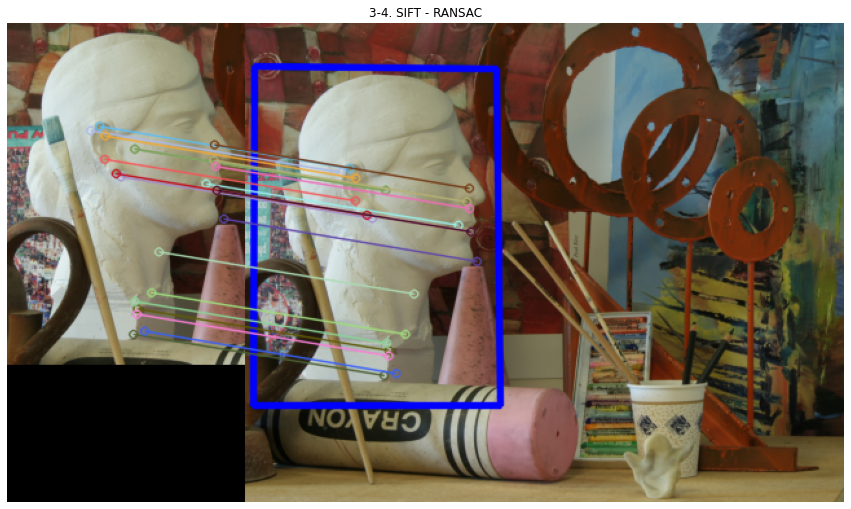

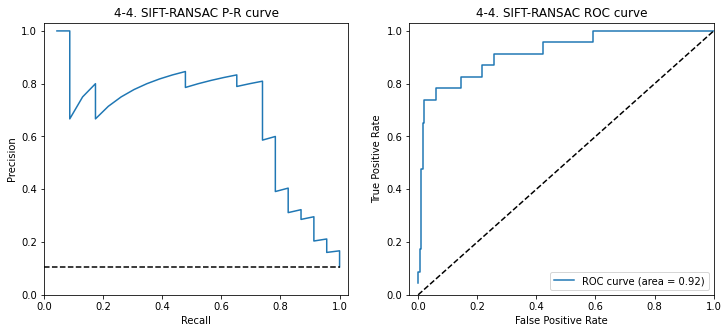

In [4]:
# Load the main image and template image
img2 = cv2.imread('./img/Art/view5.png')
img1 = cv2.imread('./template.png')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

detector = cv2.xfeatures2d.SIFT_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = matcher.match(desc1, desc2)
matches = sorted(matches, key=lambda x:x.distance)

# 매칭점으로 원근 변환 및 영역 표시
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])

# RANSAC으로 변환 행렬 근사 계산
mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
h,w = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
dst = cv2.perspectiveTransform(pts,mtrx)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# 정상치 매칭만 그리기
matchesMask = mask.ravel().tolist()
res2 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                    matchesMask = matchesMask,
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

precision, tpr, fpr = compute_tpr_fpr(matchesMask)
roc_auc = metrics.auc(fpr, tpr)

# Display the matched image
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB)), plt.title("3-4. SIFT - RANSAC"), plt.axis("off")
plt.show()

# ROC 곡선 플롯
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tpr, precision)
plt.plot([0, 1], [precision[-1], precision[-1]], 'k--')
plt.xlim([0.0, 1.03])
plt.ylim([0.0, 1.03])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('4-4. SIFT-RANSAC P-R curve')

plt.subplot(122)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('4-4. SIFT-RANSAC ROC curve')
plt.legend(loc="lower right")
plt.show()

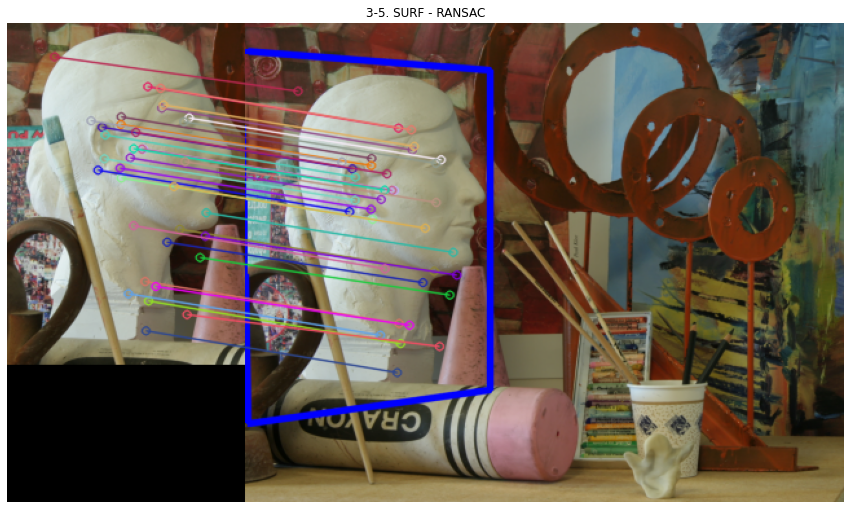

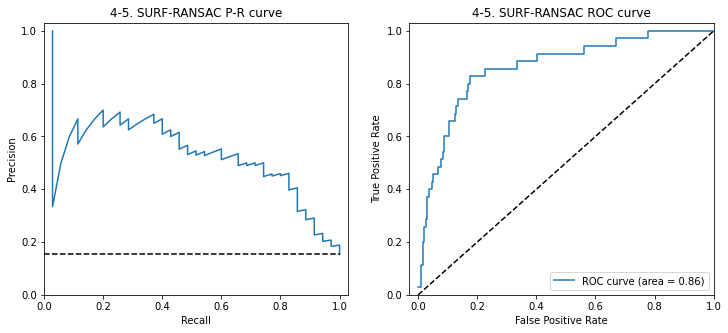

In [5]:
# Load the main image and template image
img2 = cv2.imread('./img/Art/view5.png')
img1 = cv2.imread('./template.png')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

detector = cv2.xfeatures2d.SURF_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

matcher = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
matches = matcher.match(desc1, desc2)
matches = sorted(matches, key=lambda x:x.distance)

# 매칭점으로 원근 변환 및 영역 표시
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])

# RANSAC으로 변환 행렬 근사 계산
mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
h,w = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
dst = cv2.perspectiveTransform(pts,mtrx)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# 정상치 매칭만 그리기
matchesMask = mask.ravel().tolist()
res2 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                    matchesMask = matchesMask,
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

precision, tpr, fpr = compute_tpr_fpr(matchesMask)
roc_auc = metrics.auc(fpr, tpr)

# Display the matched image
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB)), plt.title("3-5. SURF - RANSAC"), plt.axis("off")
plt.show()

# ROC 곡선 플롯
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tpr, precision)
plt.plot([0, 1], [precision[-1], precision[-1]], 'k--')
plt.xlim([0.0, 1.03])
plt.ylim([0.0, 1.03])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('4-5. SURF-RANSAC P-R curve')

plt.subplot(122)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('4-5. SURF-RANSAC ROC curve')
plt.legend(loc="lower right")
plt.show()

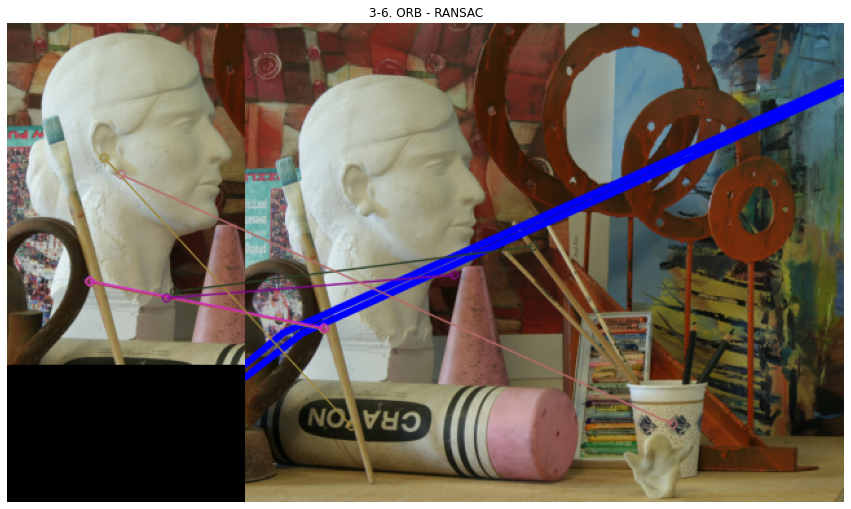

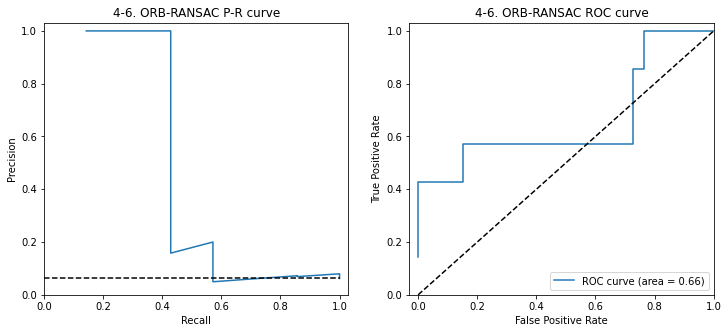

In [6]:
# Load the main image and template image
img2 = cv2.imread('./img/Art/view5.png')
img1 = cv2.imread('./template.png')
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

detector = cv2.ORB_create()
kp1, desc1 = detector.detectAndCompute(gray1, None)
kp2, desc2 = detector.detectAndCompute(gray2, None)

orb_desc_image1 = cv2.drawKeypoints(img1, kp1, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)
orb_desc_image2 = cv2.drawKeypoints(img2, kp2, None, flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(desc1, desc2)
matches = sorted(matches, key=lambda x:x.distance)

# 매칭점으로 원근 변환 및 영역 표시
src_pts = np.float32([ kp1[m.queryIdx].pt for m in matches ])
dst_pts = np.float32([ kp2[m.trainIdx].pt for m in matches ])

# RANSAC으로 변환 행렬 근사 계산
mtrx, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC)
h,w = img1.shape[:2]
pts = np.float32([ [[0,0]],[[0,h-1]],[[w-1,h-1]],[[w-1,0]] ])
dst = cv2.perspectiveTransform(pts,mtrx)
img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

# 정상치 매칭만 그리기
matchesMask = mask.ravel().tolist()
res2 = cv2.drawMatches(img1, kp1, img2, kp2, matches, None, \
                    matchesMask = matchesMask,
                    flags=cv2.DRAW_MATCHES_FLAGS_NOT_DRAW_SINGLE_POINTS)

precision, tpr, fpr = compute_tpr_fpr(matchesMask)
roc_auc = metrics.auc(fpr, tpr)

# Display the matched image
plt.figure(figsize=(15,15))
plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB)), plt.title("3-6. ORB - RANSAC"), plt.axis("off")
plt.show()

# 성능 그래프
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(tpr, precision)
plt.plot([0, 1], [precision[-1], precision[-1]], 'k--')
plt.xlim([0.0, 1.03])
plt.ylim([0.0, 1.03])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('4-6. ORB-RANSAC P-R curve')

plt.subplot(122)
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.03, 1.0])
plt.ylim([0.0, 1.03])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('4-6. ORB-RANSAC ROC curve')
plt.legend(loc="lower right")
plt.show()